In [1]:
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_features = pd.read_csv('data/train_features.csv')
train_targets_scored = pd.read_csv('data/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv')

test_features = pd.read_csv('data/test_features.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [4]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [6]:
train_targets_scored.sum()[1:].sort_values()

atp-sensitive_potassium_channel_antagonist      1
erbb2_inhibitor                                 1
diuretic                                        6
autotaxin_inhibitor                             6
protein_phosphatase_inhibitor                   6
                                             ... 
serotonin_receptor_antagonist                 404
dopamine_receptor_antagonist                  424
cyclooxygenase_inhibitor                      435
proteasome_inhibitor                          726
nfkb_inhibitor                                832
Length: 206, dtype: object

In [7]:
train_features['cp_type'].unique()

array(['trt_cp', 'ctl_vehicle'], dtype=object)

In [8]:
train_features

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [9]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

train = train.drop('sig_id', axis=1)
test = test.drop('sig_id', axis=1)

# train = train.set_index('sig_id')#train.drop('sig_id', axis=1)
# test = test.set_index('sig_id')#test.drop('sig_id', axis=1)
# target = target.set_index('sig_id')

In [10]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,...,0,0,0,0,0,0,0,0,0,0
1,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,...,0,0,0,0,0,0,0,0,0,0
2,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,...,0,0,0,0,0,0,0,0,0,0
3,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,...,0,0,0,0,0,0,0,0,0,0
4,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,-0.1777,...,0,0,0,0,0,0,0,0,0,0
21944,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,...,0,0,0,0,0,0,0,0,0,0
21945,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,...,0,0,0,0,0,0,0,0,0,0
21946,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,...,0,0,0,0,0,0,0,0,0,0


In [11]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=5)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,...,0,0,0,0,0,0,0,0,0,0
1,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,...,0,0,0,0,0,0,0,0,0,2
2,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,...,0,0,0,0,0,0,0,0,0,1
3,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,...,0,0,0,0,0,0,0,0,0,2
4,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,-0.1777,...,0,0,0,0,0,0,0,0,0,0
21944,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,...,0,0,0,0,0,0,0,0,0,4
21945,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,...,0,0,0,0,0,0,0,0,0,0
21946,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,...,0,0,0,0,0,0,0,0,0,1


In [12]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,...,0,0,0,0,0,0,0,0,0,0
1,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,...,0,0,0,0,0,0,0,0,0,0
2,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,...,0,0,0,0,0,0,0,0,0,0
3,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,...,0,0,0,0,0,0,0,0,0,0
4,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,-0.1777,...,0,0,0,0,0,0,0,0,0,0
21944,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,...,0,0,0,0,0,0,0,0,0,0
21945,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,...,0,0,0,0,0,0,0,0,0,0
21946,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,...,0,0,0,0,0,0,0,0,0,0


In [13]:
target

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21945,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
cat_vars = ['cp_time', 'cp_dose']

dep_vars = [x for x in train.columns if x in train_targets_scored.columns]

cont_vars = [x for x in train.columns if x not in cat_vars and x not in dep_vars]

In [15]:
# train['targets'] = (train[dep_vars] == 1).apply(lambda x: ','.join(x.index[x]), axis=1)

In [16]:
#train = train.drop(dep_vars, axis=1)

In [17]:
len(cat_vars)

2

In [18]:
len(cont_vars)

872

In [19]:
len(dep_vars)

206

In [20]:
train.shape

(21948, 1080)

In [21]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,...,0,0,0,0,0,0,0,0,0,0
1,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,...,0,0,0,0,0,0,0,0,0,0
2,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,...,0,0,0,0,0,0,0,0,0,0
3,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,...,0,0,0,0,0,0,0,0,0,0
4,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,-0.1777,...,0,0,0,0,0,0,0,0,0,0
21944,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,...,0,0,0,0,0,0,0,0,0,0
21945,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,...,0,0,0,0,0,0,0,0,0,0
21946,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,...,0,0,0,0,0,0,0,0,0,0


In [22]:
%reload_ext autoreload
%autoreload 2

from fastai.tabular import *

In [23]:
procs=[FillMissing, Categorify, Normalize]

In [24]:
test

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,0.2221,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,0.4022,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,-0.1799,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
3,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,0.6365,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380
4,48,D2,0.3658,0.5536,-0.6898,-1.6270,0.5239,-0.3832,-0.4653,1.0070,...,-0.8820,-0.5378,0.2314,-0.7602,-0.9982,-0.6570,-0.2593,-0.2174,0.0044,-1.4650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,24,D1,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,0.0640,-0.6316,...,-1.1790,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600
3620,24,D1,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,-0.7437,-0.0143,...,0.0210,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934
3621,72,D1,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,-0.0166,0.7501,...,0.4418,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504
3622,48,D2,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,-0.3611,-1.3020,...,0.3079,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484


In [25]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,...,0,0,0,0,0,0,0,0,0,0
1,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,...,0,0,0,0,0,0,0,0,0,0
2,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,...,0,0,0,0,0,0,0,0,0,0
3,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,...,0,0,0,0,0,0,0,0,0,0
4,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,-0.1777,...,0,0,0,0,0,0,0,0,0,0
21944,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,...,0,0,0,0,0,0,0,0,0,0
21945,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,...,0,0,0,0,0,0,0,0,0,0
21946,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,...,0,0,0,0,0,0,0,0,0,0


In [26]:
FOLD = 0
valid_idx = folds.query(f"kfold=={FOLD}").index

data = (TabularList.from_df(train, cat_names=cat_vars, cont_names=cont_vars, 
                            procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_vars)
                .add_test(TabularList.from_df(test, cat_names=cat_vars, cont_names=cont_vars))
                .databunch(bs=4))

In [27]:
data.show_batch()

cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680,g-681,g-

In [41]:
y_range = torch.tensor([0, 1], device=defaults.device)

learn = tabular_learner(data, layers=[512, 256], ps=[0.0, 0.0], emb_drop=0.0,
                        y_range=y_range, metrics=exp_rmspe)

In [42]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(872, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=878, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=206, bias=True)
  )
)

In [43]:
learn.lr_find(end_lr=100)


epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


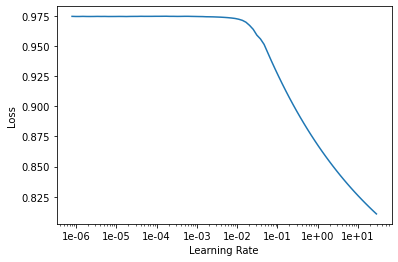

In [44]:
learn.recorder.plot()


In [45]:
# def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .00001, adjust_value:float = 1, plot:bool = False) -> float:
#     #Run the Learning Rate Finder
#     model.lr_find()
    
#     #Get loss values and their corresponding gradients, and get lr values
#     losses = np.array(model.recorder.losses)
#     assert(lr_diff < len(losses))
#     loss_grad = np.gradient(losses)
#     lrs = model.recorder.lrs
    
#     #Search for index in gradients where loss is lowest before the loss spike
#     #Initialize right and left idx using the lr_diff as a spacing unit
#     #Set the local min lr as -1 to signify if threshold is too low
#     r_idx = -1
#     l_idx = r_idx - lr_diff
#     while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
#         local_min_lr = lrs[l_idx]
#         r_idx -= 1
#         l_idx -= 1

#     lr_to_use = local_min_lr * adjust_value
    
#     if plot:
#         # plots the gradients of the losses in respect to the learning rate change
#         plt.plot(loss_grad)
#         plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
#         plt.ylabel("Loss")
#         plt.xlabel("Index of LRs")
#         plt.show()

#         plt.plot(np.log10(lrs), losses)
#         plt.ylabel("Loss")
#         plt.xlabel("Log 10 Transform of Learning Rate")
#         loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
#         plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
#         plt.show()
        
#     return lr_to_use

In [46]:
# find_appropriate_lr(learn, plot=True)

In [47]:
data.show_batch()

cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680,g-681,g-

In [48]:
learn.fit_one_cycle(25, 1e-3, wd=1e-5)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.695279,0.694591,0.037497,00:30
1,0.693151,0.693147,0.037861,00:30
2,0.693151,0.693147,0.037861,00:29
3,0.693151,0.693147,0.037861,00:29


KeyboardInterrupt: 